In [1]:
%%capture

import os
import gym
import numpy as np
import pandas as pd
import schedgym.envs as deeprm

from stable_baselines import PPO2 as PPO
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import FeedForwardPolicy

In [2]:
SLOTS: int = 10
BACKLOG: int = 60
TIME_LIMIT: int = 50
TIME_HORIZON: int = 20

workload = deeprm.deeprm_env.DEFAULT_WORKLOAD.copy()
workload['new_job_rate'] = .3

In [3]:
def setup_environment(envname, workload=None) -> deeprm.DeepRmEnv:
    kwargs = {
        'job_slots': SLOTS,
        'time_limit': TIME_LIMIT,
        'backlog_size': BACKLOG,
        'time_horizon': TIME_HORIZON,
        'use_raw_state': False,
    }
    if workload is not None:
        kwargs['workload'] = workload
    env: deeprm.DeepRmEnv = gym.make(
        envname, **kwargs
    )
    env.reset()

    return env

In [4]:
class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           net_arch=[dict(pi=[20],
                                                          vf=[20])],
                                           feature_extraction="mlp")

In [5]:
env = setup_environment('DeepRM-v0', workload)
env = DummyVecEnv([lambda: env])
model = PPO(CustomPolicy, env, verbose=1,
            learning_rate=5e-4, ent_coef=0.01)

In [6]:
total_epochs = 250
timesteps_in_epoch = 1000
for i in range(total_epochs):
    print(f'\rRunning training epoch: {i}/{total_epochs}', end='')
    model.learn(total_timesteps=timesteps_in_epoch,
                reset_num_timesteps=(i == 0),
                log_interval=150)
    model.save(f'ppo_deeprm-{i}')

model.save('ppo_deeprm')

Running training epoch: 9/250

KeyboardInterrupt: 

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('bmh')  # Bayesian Methods for Hackers

In [8]:
def discount(x, gamma):
    """Returns discounted returns for all time steps in an episode.
    
    Given vector x, computes a vector y such that
    y[i] = x[i] + gamma * x[i+1] + gamma^2 x[i+2] + ...
    """
    out = np.zeros(len(x))
    out[-1] = x[-1]
    for i in reversed(list(range(len(x)-1))):
        out[i] = x[i] + gamma*out[i+1]
    return out

In [9]:
def run_baselines_model(args):
    env, model, i, raw, workload = args
    env = setup_environment(env, workload=workload)
    env.use_raw_state = raw
    np.random.seed(i)
    rewards = []
    state = env.reset()
    for _ in range(200):
        action, _ = model.predict(state, deterministic=True)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
    return np.sum(rewards), np.mean(env.slowdown), discount(rewards, 0.99)[0],\
           np.mean(rewards)

In [10]:
from IPython.utils import io

def evaluate(model_class, env, template, runs=30, total_epochs=total_epochs):
  rewards, slowdowns, returns, means = [], [], [], []
  for i in range(total_epochs):
    print(f'\rEvaluating epoch {i}/{total_epochs}', end='')
    with io.capture_output():
      model = model_class.load(template.format(i))
    reward, slowdown, ret, mean = zip(
      *[run_baselines_model((env, model, j, False, workload))
        for j in range(runs)]
    )
    rewards.append(reward)
    slowdowns.append(slowdown)
    returns.append(ret)
    means.append(mean)
  return rewards, slowdowns, returns, means

In [11]:
rewards, slowdowns, returns, means = evaluate(
    PPO, 'DeepRM-v0', 'ppo_deeprm-{}', 60
)

Evaluating epoch 249/250

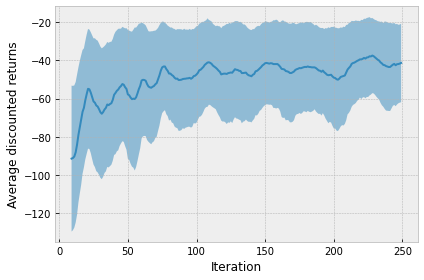

In [12]:
df = pd.DataFrame({
  'mean': [np.mean(r) for r in returns],
  'std': [np.std(r) for r in returns]
})

fig, ax = plt.subplots()

y = df['mean'].rolling(window=10).mean()
yerror = df['std'].rolling(window=10).mean()
x = y.index

ax.plot(x, y)
ax.fill_between(x, y - yerror, y + yerror, alpha=.5)
ax.set_ylabel('Average discounted returns')
ax.set_xlabel('Iteration')
plt.tight_layout()
plt.show()

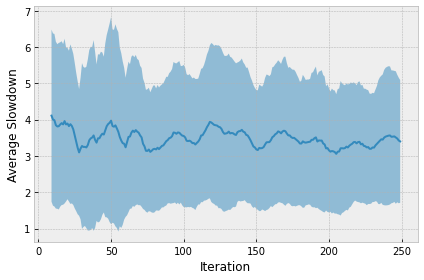

In [13]:
df = pd.DataFrame({
  'mean': [np.mean(s) for s in slowdowns],
  'std': [np.std(s) for s in slowdowns]
})

fig, ax = plt.subplots()

y = df['mean'].rolling(window=10).mean()
yerror = df['std'].rolling(window=10).mean()
x = y.index

ax.plot(x, y)
ax.fill_between(x, y - yerror, y + yerror, alpha=.5)
ax.set_ylabel('Average Slowdown')
ax.set_xlabel('Iteration')
plt.tight_layout()
plt.show()

In [ ]:
import gym
import schedgym.envs as schedgym

env = gym.make('DeepRM-v0', use_raw_state=True)
env.reset()

for _ in range(200):
  env.render()
  observation, reward, done, info = env.step(env.action_space.sample())
env.close()

/usr/local/lib/python3.7/dist-packages/pyglet/window/__init__.py:658: UserWarning: 
Your graphics drivers do not support OpenGL 2.0.
You may experience rendering issues or crashes.
NVIDIA Corporation
Quadro P2000/PCIe/SSE2
1.4 (4.6.0 NVIDIA 471.68)
  warnings.warn(message)


In [7]:
import gym
import schedgym.envs as schedgym

env = gym.make('DeepRM-v0', use_raw_state=True)
env.reset()

for _ in range(200):
  env.render()
  observation, reward, done, info = env.step(env.action_space.sample())
env.close()

NoSuchDisplayException: Cannot connect to "None"

In [ ]:
import gym
import schedgym.envs as schedgym

env = gym.make('DeepRM-v0', use_raw_state=True)
env.reset()

for _ in range(200):
  env.render()
  observation, reward, done, info = env.step(env.action_space.sample())
env.close()

/usr/local/lib/python3.7/dist-packages/pyglet/window/__init__.py:658: UserWarning: 
Your graphics drivers do not support OpenGL 2.0.
You may experience rendering issues or crashes.
NVIDIA Corporation
Quadro P2000/PCIe/SSE2
1.4 (4.6.0 NVIDIA 452.25)
  warnings.warn(message)


In [5]:
import gym
import schedgym.envs as schedgym

env = gym.make('DeepRM-v0', use_raw_state=True)
print(env.action_space)

Discrete(6)
